In [31]:
import mysql.connector
import os_environt_variables
import pandas as pd
import os
import matplotlib.pyplot as plt

In [2]:

conn = mysql.connector.connect(host=os.environ.get('HOST_BD'),user=os.environ.get('USER_BD'),password= os.environ.get('PASSWORD_BD'),database=os.environ.get('DATABASE_BD') )

if conn.is_connected():
    print("Conexión exitosa a la base de datos.")
else:
    print("No se pudo establecer la conexión a la base de datos.") 


Conexión exitosa a la base de datos.


In [3]:
cursor = conn.cursor()

query = """ 
SELECT 
    se.student_id, 
    si.date_registered,
    MIN(se.date_watched) as first_date_watched,
    MIN(sp.date_purchased) as first_date_purchased,
    TIMESTAMPDIFF(DAY, si.date_registered, MIN(se.date_watched)) as date_diff_reg_watch,
    TIMESTAMPDIFF(DAY, MIN(se.date_watched), MIN(sp.date_purchased)) as date_diff_watch_purch

FROM 
    db_course_conversions.student_info as si
LEFT JOIN 
    db_course_conversions.student_engagement as se 
ON 
    si.student_id = se.student_id
LEFT JOIN 
    db_course_conversions.student_purchases as sp 
ON 
    se.student_id = sp.student_id
GROUP BY 
    si.student_id, si.date_registered
HAVING 
    se.student_id IS NOT NULL AND (date_diff_watch_purch >= 0 OR date_diff_watch_purch IS NULL)
"""
cursor.execute(query)
datos = cursor.fetchall()
df = pd.DataFrame(datos, columns = [x[0] for x in cursor.description])
conn.close()

In [42]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20255 entries, 0 to 20254
Data columns (total 6 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   student_id             20255 non-null  int64  
 1   date_registered        20255 non-null  object 
 2   first_date_watched     20255 non-null  object 
 3   first_date_purchased   2286 non-null   object 
 4   date_diff_reg_watch    20255 non-null  int64  
 5   date_diff_watch_purch  2286 non-null   float64
dtypes: float64(1), int64(2), object(3)
memory usage: 949.6+ KB


In [50]:
#TASA DE CONVERSION

total_conversion = df['date_diff_watch_purch'].count()/df['date_registered'].count()
print(f'La Tasa de conversion de usuarios asistentes a usuarios de suscripcion es : {total_conversion*100:.3f}%')

La Tasa de conversion de usuarios asistentes a usuarios de suscripcion es : 11.286%


In [23]:
# Teniendo los datos calculados, ahora vamos a aplicar una serie de analisis estadisticos tratando de obtener algunos insights
print(df.date_diff_reg_watch.describe())
print(f"la mediana es: {df['date_diff_reg_watch'].median()} y la moda es: {df['date_diff_reg_watch'].mode()} ")

count    20255.000000
mean         3.423895
std         19.294891
min          0.000000
25%          0.000000
50%          0.000000
75%          0.000000
max        313.000000
Name: date_diff_reg_watch, dtype: float64
la mediana es: 0.0 y la moda es: 0    0
Name: date_diff_reg_watch, dtype: int64 


Vamos a revisar más a fondo la distribución de los datos, ya que tenemos un rango de valores bastante amplio, eso nos puede decir que hay una dispersión de los datos bastante amplia.

observando nuestras estadísticas, tenemos una media de 3.42 días que pasan en que un usuario se inscribe hasta que tiene asiste a su primera transmisión, pero esta información debe ser analizada en perspectiva, ya que, si observamos la distribución de cuartiles, hasta el cuartil 3, ósea el 75% de los datos están concentrados en el cero (0), teniendo esto en cuenta se concluye que:

1. los valores atípicos están afectando la media y entregando una media alejada de su mediana, mostrando que tenemos valores atípicos a la derecha (usuarios que ha pasado mucho tiempo desde que se inscribieron hasta que asistieron a su primera transmisión.)

2. observando nuestra desviación estándar de 19.29, podemos dar fe de que los valores atípicos tienen una dispersión importante, pero sin tener el suficiente peso para tener en cuenta para dar un cambio drástico en la dirección de la estrategia de marketing de contenidos utilizada para conversión en esa sección del embudo.


In [9]:
print(df.date_diff_reg_watch.value_counts().head(10))

date_diff_reg_watch
0     17220
1       934
2       309
3       170
4       158
5       126
6       104
7        75
8        51
10       47
Name: count, dtype: int64


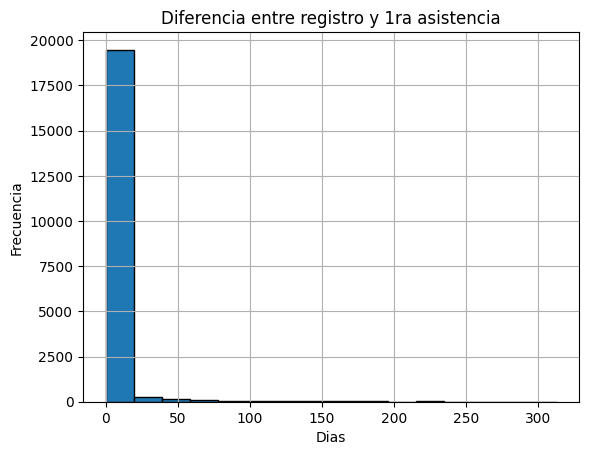

In [32]:
df.date_diff_reg_watch.hist(bins = 16, edgecolor = 'black') #aplicamos la regla de sturges para calcular un numero optimo de clases para la cantidad de datos que tenemos
plt.xlabel('Dias')
plt.ylabel('Frecuencia')
plt.title('Diferencia entre registro y 1ra asistencia')
plt.show()

Como observamos en el gráfico, podemos darnos cuenta de que un porcentaje muy elevado de los datos se ubica en la primera clase (aproximadamente los 20 primeros días), alrededor del 98% de los valores se acomodan en este sector,  distribuidos en el día cero en casi su totalidad.

Esto demuestra que los esfuerzos del embudo son bastante buenos para esta etapa, que busca que el cliente apenas complete su registro consuma el contenido de promoción en las primeras 24 horas después de su registro.


In [37]:
print(df.date_diff_watch_purch.describe())
print(f"la mediana es: {df['date_diff_watch_purch'].median()} y la moda es: {df['date_diff_watch_purch'].mode()}  ")
print(df.date_diff_watch_purch.value_counts().head(10))


count    2286.000000
mean       26.247157
std        71.411457
min         0.000000
25%         0.000000
50%         1.000000
75%         7.000000
max       573.000000
Name: date_diff_watch_purch, dtype: float64
la mediana es: 1.0 y la moda es: 0    0.0
Name: date_diff_watch_purch, dtype: float64  
date_diff_watch_purch
0.0    1128
1.0     223
2.0     112
3.0      69
4.0      68
7.0      54
6.0      52
5.0      44
8.0      20
9.0      16
Name: count, dtype: int64


In [48]:
top_3 = df['date_diff_watch_purch'].value_counts().head(3).sum()
total_registros = df['date_diff_watch_purch'].count()

freq_72_horas = top_3/total_registros
print(f'la conversion de clientes en las primeras 72 horas despues de la primera transmision es: {freq_72_horas*100:.3f}%')

la conversion de clientes en las primeras 72 horas despues de la primera transmision es: 63.998%


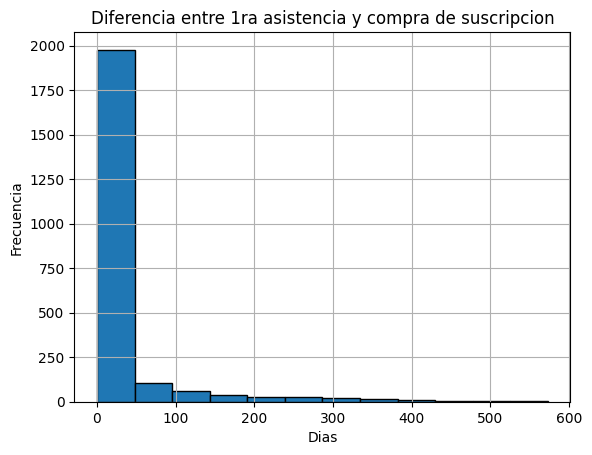

In [33]:
df.date_diff_watch_purch.hist(bins = 12, edgecolor = 'black') #aplicamos la regla de sturges para calcular un numero optimo de clases para la cantidad de datos que tenemos
plt.xlabel('Dias')
plt.ylabel('Frecuencia')
plt.title('Diferencia entre 1ra asistencia y compra de suscripcion')
plt.show()

Observando las estadísticas podemos inferir que:

1. los valores atípicos en este caso tienen un mayor impacto en el valor de la media (26,24 días), ya que, si observamos los cuartiles de esta distribución de valores, encontramos que hasta el 75% (Q3) presentábamos hasta el valor de 7, por lo que la media se encuentra ubicada en el último cuartil, bastante alejado de su mediana, esto nos demuestra cuantitativamente, que tenemos valores atípicos altos.

2. en casi la totalidad de los 3 primeros cuartiles de conversión se encuentran en las primeras 72 horas después de la primera asistencia a la transmisión de ventas, en deducción a esto, 3/4 partes de nuestros clientes ha tomado nuestra suscripción en caliente (apertura del carrito), los demás clientes han esperado al cierre, o han requerido de alguna oferta especial.

3. Se necesita una evaluación financiera para contrastar el valor de la tasa de conversión del 11.289% que tenemos a usuarios de pago, ya que, sin esta, solo se podría comparar los resultados con otras estrategias de marketing, sin tener en cuenta los costos y la inversión en mercadeo que se hace para este fin.


## Informacion adicional

Como valor agregado al departamento de marketing, haremos una investigacion de la cantidad de impactos necesarios para que un cliente tome la decision de comprar una suscripcion, tambien los usuarios que no toman la decision de adquirir una suscripcion, que tanta cantidad de veces accede a nuestros recursos.

In [51]:
conn = mysql.connector.connect(host=os.environ.get('HOST_BD'),user=os.environ.get('USER_BD'),password= os.environ.get('PASSWORD_BD'),database=os.environ.get('DATABASE_BD') )

if conn.is_connected():
    print("Conexión exitosa a la base de datos.")
else:
    print("No se pudo establecer la conexión a la base de datos.") 


Conexión exitosa a la base de datos.


nos aseguramos de limpiar los datos para evitar errores en los registros

In [52]:
cursor = conn.cursor()

query = """ 
SELECT 
    si.student_id,
    si.date_registered,
    se.date_watched,
    sp.date_purchased
FROM 
    db_course_conversions.student_info as si
LEFT JOIN 
    db_course_conversions.student_engagement as se
ON 
    si.student_id = se.student_id
LEFT JOIN 
    db_course_conversions.student_purchases as sp
ON 
    se.student_id = sp.student_id
WHERE 
    sp.date_purchased >= se.date_watched;
"""
cursor.execute(query)
datos = cursor.fetchall()
df_base = pd.DataFrame(datos, columns = [x[0] for x in cursor.description])
conn.close()

In [53]:
df_base

,student_id,date_registered,date_watched,date_purchased
0,255203,2021-12-01,2021-12-01,2021-12-01
1,255204,2021-12-01,2021-12-01,2023-03-01
2,255204,2021-12-01,2021-12-01,2021-12-01
3,255204,2021-12-01,2021-12-02,2023-03-01
4,255204,2021-12-01,2021-12-03,2023-03-01
...,...,...,...,...
52242,296863,2022-10-30,2022-10-30,2022-10-30
52243,296865,2022-10-30,2022-10-30,2022-10-30
52244,296869,2022-10-30,2022-10-30,2022-10-30
52245,296892,2022-10-30,2022-10-30,2022-11-25
